## Loading the data

In [21]:
import numpy as np
import pandas as pd
#import missingno as msno
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.stats import chi2_contingency
import seaborn as sns
#import folium
#from folium import plugins 
#from folium.plugins import HeatMap, MarkerCluster
#import shapely
import json 
#from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
#import branca
#import branca.colormap as cm
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

In [22]:
PATH = {}
PATH["data_raw"] = "../../data/raw/"
PATH["data_interim"] = "../../data/interim/"
PATH["data_processed"] = "../../data/processed/"
PATH["data_external"] = "../../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]

In [23]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['de_corona'] = pd.read_csv(corona, sep='\s+', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\s+', parse_dates=['date'], date_parser=dateparse)
additional = pd.read_csv('../../Data/Raw/weather/weather2.csv', sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = raw_data['weather'].append(additional)
raw_data['weather']= pd.concat([raw_data['weather'], additional], axis=0)

with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.loads(f.read())

In [24]:
HEADERS = ['de_corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

de_corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (25536, 9)


In [25]:
#Filtering data
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
weather_data_de.reset_index(drop=True, inplace=True)

## Stuff from the main with few changes

In [26]:
## FROM MAIN ## 
#similar to how Michele did, creating the corona dataset with the regions
corona_df = raw_data['de_corona']
ss = dict()
for i in country_metadata['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)

In [27]:
## FROM MAIN ## 
#total  of covid cases per region
meta_df = pd.DataFrame(country_metadata['country_metadata'])
sorted_country_metadata = meta_df.sort_values(by = 'iso3166-2_name_en')
corona_by_region  = pd.DataFrame(raw_data['de_corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values

In [28]:
## FROM MAIN ##
#merging the corona dataset with the weather dataset
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["region_code", "region"], axis = 1)

### Monthly analysis

In [29]:
weather_date = pd.to_datetime(weather_data_de['date'])
weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
weather_2021=pd.DataFrame(weather_data_de[weather_date.dt.year == 2021])

weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
weather_month_2021 = pd.DataFrame(weather_2021.groupby(weather_date.dt.month).mean())
right_weather_one = weather_month_2020.append(weather_month_2021, sort=False)

celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
right_weather_one['Temp_Celsius'] = celsius

In [30]:
corona_date = pd.to_datetime(raw_data['de_corona']['date'])
corona_2020=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2020])
corona_2021=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2021])

corona_2021_month_sum = pd.DataFrame(corona_2021.groupby(corona_date.dt.month).sum())
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
right_one = corona_month_sum.append(corona_2021_month_sum)

# Task 1: single variable analysis 

### Regional means

<AxesSubplot:xlabel='iso3166-2'>

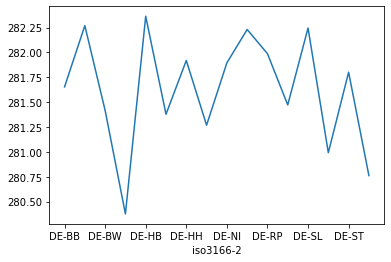

In [31]:
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
weather_by_region["TemperatureAboveGround"].plot()

<AxesSubplot:xlabel='region_code'>

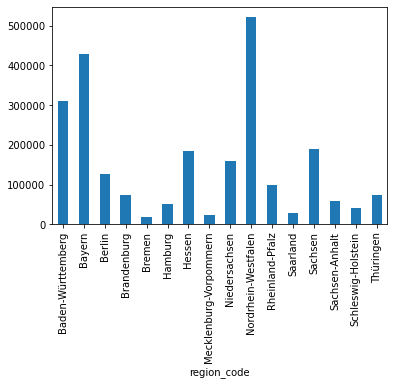

In [32]:
## corona cases by region
corona_by_region["confirmed_addition"].plot.bar(rot=90)

<AxesSubplot:xlabel='region_code'>

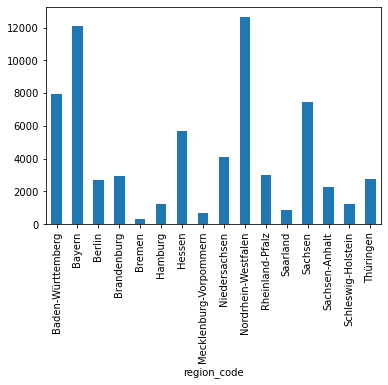

In [42]:
# death by region
corona_by_region["deceased_addition"].plot.bar(rot=90)

# Temperature
### Temperature plot daily

<AxesSubplot:xlabel='date'>

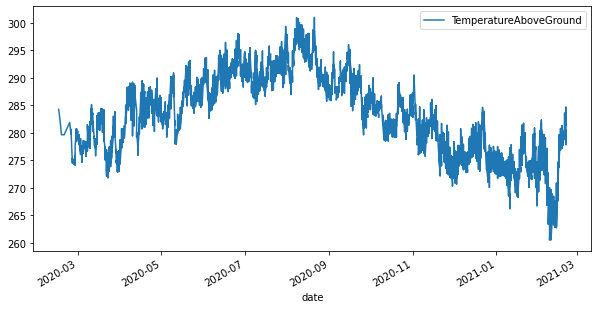

In [34]:
daily_corona_weather.plot(x = "date", y = "TemperatureAboveGround", figsize=(10,5))

### Temperature plot monthly 

<AxesSubplot:xlabel='date'>

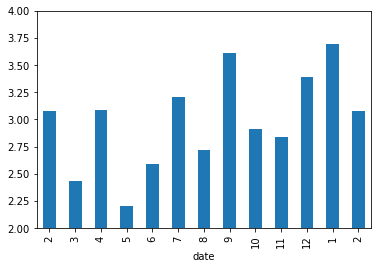

In [40]:
right_weather_one["Temp_Celsius"].plot.bar(ylim= [2,4])

# Corona cases daily

<AxesSubplot:xlabel='date'>

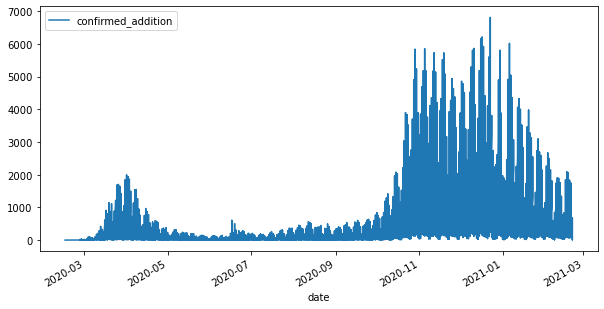

In [36]:
## Confimed cases
daily_corona_weather.plot(x = "date", y = "confirmed_addition", figsize=(10,5))

<AxesSubplot:xlabel='date'>

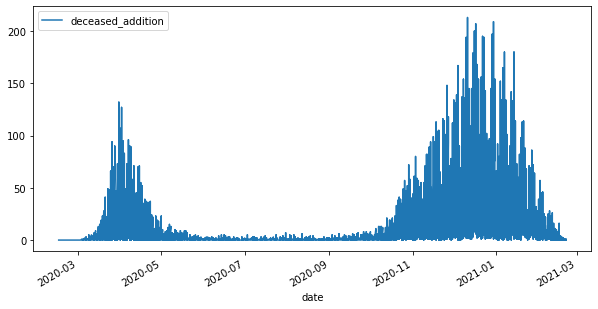

In [37]:
## deceased
daily_corona_weather.plot(x = "date", y = "deceased_addition", figsize=(10,5))

# Corona cases monthly

<AxesSubplot:xlabel='date'>

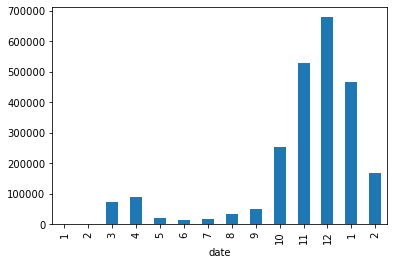

In [38]:
right_one["confirmed_addition"].plot.bar()

<AxesSubplot:xlabel='date'>

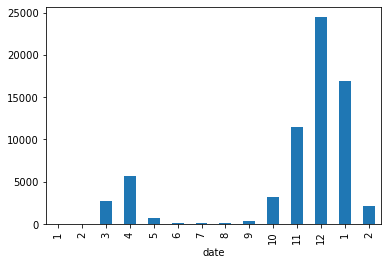

In [39]:
right_one["deceased_addition"].plot.bar()

In [43]:
print(":(")

:(
